### I. Import data and libraries:

In [1]:
import os
import tensorflow as tf
import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from PIL import Image


In [2]:
# Show TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if TensorFlow is using GPU
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using GPU")
    print("GPU devices:", tf.config.list_physical_devices('GPU'))
else:
    print("TensorFlow is not using GPU")

TensorFlow version: 2.10.0
TensorFlow is using GPU
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
dataset_path = r"C:\D\AI\Dataset\Dataset small\tomato"

image_sizes = set()

def get_image_size(image_path):
    with Image.open(image_path) as img:
        return img.size

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png', '.gif')):
            image_path = os.path.join(root, file)
            size = get_image_size(image_path)
            image_sizes.add(size)

for size in image_sizes:
    print(f"Image size: {size}")
print("Number of image size:", len(image_sizes))

Image size: (256, 256)
Number of image size: 1


### II. Data exploration

In [2]:
batch_size = 32
img_height = 224
img_width = 224

In [3]:
train_data = tf.keras.utils.image_dataset_from_directory(
    r"C:\D\AI\Dataset\Dataset small\tomato\train",
    color_mode = 'rgb', 
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 10000 files belonging to 10 classes.


In [4]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\D\AI\Dataset\Dataset small\tomato\val",
    color_mode = 'rgb', 
    image_size = (img_height, img_width),
    batch_size = batch_size) 

Found 1000 files belonging to 10 classes.


In [ ]:
class_names = train_data.class_names
print(f"Number of classes: {len(class_names)}")
list_class = class_names
class_names

Number of classes: 10


['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [10]:
print(f"Type of train_data: {type(train_data)}")
print(f"Details of train_data: {train_data}")
print(f"Element specification of train_data: {train_data.element_spec}")

Type of train_data: <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Details of train_data: <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Element specification of train_data: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


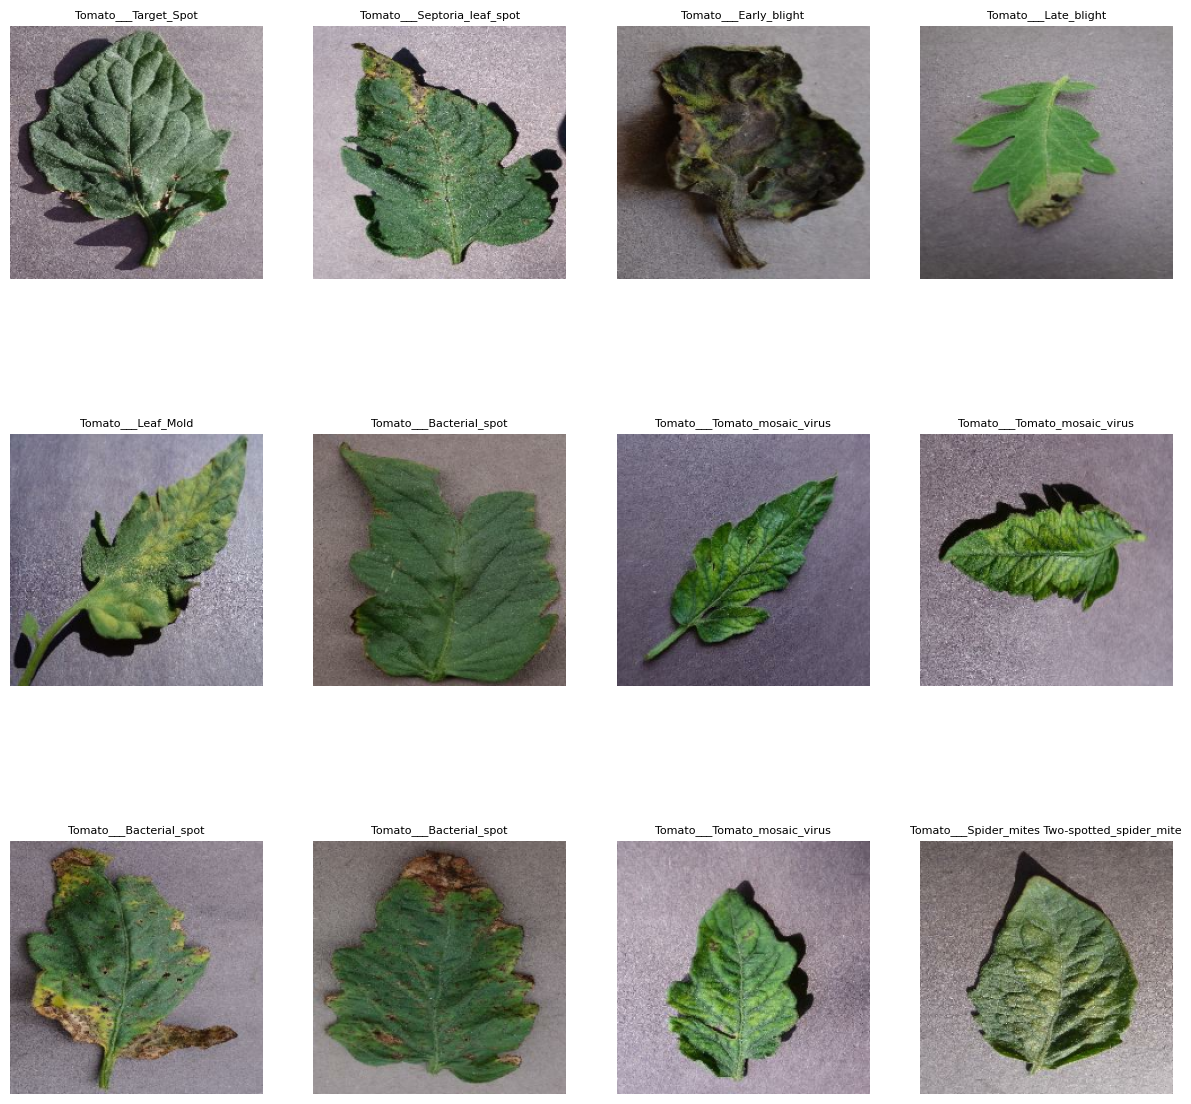

In [ ]:
plt.figure(figsize=(15, 15))

# Display the size of 12 random images in 1 batch
for image, labels in train_data.take(1):
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(train_data.class_names[labels[i]], fontsize=8) 
        plt.axis("off")

### III. Build model + Train model + Evaluate model

In [5]:
train_data = train_data.map(lambda x, y: (x / 255.0, (y, y, y)))
val_data = val_data.map(lambda x, y: (x / 255.0, (y, y, y)))

In [6]:
for batch in train_data:
    print(batch)
    break

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[0.58431375, 0.60784316, 0.7490196 ],
         [0.58067226, 0.6042017 , 0.74537814],
         [0.58207285, 0.60560226, 0.7467787 ],
         ...,
         [0.23931679, 0.2001011 , 0.33343443],
         [0.22669028, 0.1874746 , 0.32080793],
         [0.22621073, 0.18699504, 0.32032835]],

        [[0.59047616, 0.61400557, 0.7551821 ],
         [0.58665466, 0.6101841 , 0.75136054],
         [0.587395  , 0.6109244 , 0.7521009 ],
         ...,
         [0.26100478, 0.22094874, 0.35428208],
         [0.25440162, 0.21434557, 0.34767893],
         [0.23005167, 0.18999563, 0.32332897]],

        [[0.6038215 , 0.6273509 , 0.7685274 ],
         [0.5980392 , 0.6215686 , 0.7627451 ],
         [0.59635854, 0.61988795, 0.7610644 ],
         ...,
         [0.27975205, 0.23661476, 0.36814734],
         [0.28023207, 0.2370948 , 0.36982793],
         [0.24675809, 0.20362084, 0.33435306]],

        ...,

        [[0.5636056 , 0.5888157 

In [7]:
# Using Class

# Class to create InceptionV1 Module
class InceptionModule(layers.Layer):
    def __init__(self, filters_1x1, filters_3x3_reduce, filters_3x3, 
                 filters_5x5_reduce, filters_5x5, filters_pool_proj):
        super().__init__()
        
        # Branch 1: 1x1 convolution
        self.branch1x1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')
        
        # Branch 2: 1x1 convolution followed by 3x3 convolution
        self.branch3x3 = tf.keras.Sequential([
            layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu'),
            layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')
        ])
        
        # Branch 3: 1x1 convolution followed by 5x5 convolution
        self.branch5x5 = tf.keras.Sequential([
            layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu'),
            layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')
        ])
        
        # Branch 4: Max pooling followed by 1x1 convolution
        self.branch_pool = tf.keras.Sequential([
            layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same'),
            layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')
        ])
        
    def call(self, inputs):
        branch1x1 = self.branch1x1(inputs)
        branch3x3 = self.branch3x3(inputs)
        branch5x5 = self.branch5x5(inputs)
        branch_pool = self.branch_pool(inputs)
        
        # Combine branches
        output = layers.concatenate([branch1x1, branch3x3, branch5x5, branch_pool], axis=-1)
        return output


# Class to create the Auxiliary Classifier
class AuxiliaryClassifier(layers.Layer):
    def __init__(self, num_classes):
        super().__init__()
        self.avg_pool = layers.AveragePooling2D((5, 5), strides=(3, 3))
        self.conv = layers.Conv2D(128, (1, 1), padding='same', activation='relu')
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(1024, activation='relu')
        self.dropout = layers.Dropout(0.7)
        self.fc2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.avg_pool(inputs)
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Class to create Local Response Normalization (LRN) Layer
class LRN(layers.Layer):
    def __init__(self, depth_radius=5, bias=1, alpha=1e-4, beta=0.75):
        super().__init__()
        self.depth_radius = depth_radius
        self.bias = bias
        self.alpha = alpha
        self.beta = beta

    def call(self, inputs):
        return tf.nn.local_response_normalization(
            inputs,
            depth_radius=self.depth_radius,
            bias=self.bias,
            alpha=self.alpha,
            beta=self.beta
        )


# Class to create InceptionV1 Model
class InceptionV1(tf.keras.Model):
    def __init__(self, input_shape=(224, 224, 3), num_classes=1000):
        super().__init__()
        
        # Inception v1 Stem
        self.conv1 = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu', input_shape=input_shape)
        self.pool1 = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')
        
        self.lrn1 = LRN()
        
        self.conv2 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')
        self.conv3 = layers.Conv2D(192, (3, 3), padding='same', activation='relu')
        
        self.lrn2 = LRN()
        
        self.pool2 = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')

        # Inception modules
        self.inception_3a = InceptionModule(64, 96, 128, 16, 32, 32)
        self.inception_3b = InceptionModule(128, 128, 192, 32, 96, 64)
        self.pool3 = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')

        self.inception_4a = InceptionModule(192, 96, 208, 16, 48, 64)
        self.aux1 = AuxiliaryClassifier(num_classes)  # Auxiliary Classifier 1

        self.inception_4b = InceptionModule(160, 112, 224, 24, 64, 64)
        self.inception_4c = InceptionModule(128, 128, 256, 24, 64, 64)
        self.inception_4d = InceptionModule(112, 144, 288, 32, 64, 64)
        self.aux2 = AuxiliaryClassifier(num_classes)  # Auxiliary Classifier 2

        self.inception_4e = InceptionModule(256, 160, 320, 32, 128, 128)
        self.pool4 = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')

        self.inception_5a = InceptionModule(256, 160, 320, 32, 128, 128)
        self.inception_5b = InceptionModule(384, 192, 384, 48, 128, 128)

        # Global Average Pooling and Fully Connected Layer
        self.global_avg_pool = layers.GlobalAveragePooling2D()
        self.dropout = layers.Dropout(0.4)
        self.fc = layers.Dense(num_classes, activation='softmax')
    
    def call(self, inputs):
        # Stem
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.lrn1(x)
        
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.lrn2(x)
        x = self.pool2(x)

        # Inception modules
        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.pool3(x)

        x = self.inception_4a(x)
        aux1 = self.aux1(x)

        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        aux2 = self.aux2(x)

        x = self.inception_4e(x)
        x = self.pool4(x)

        x = self.inception_5a(x)
        x = self.inception_5b(x)

        # Global Average Pooling và Fully Connected Layer
        x = self.global_avg_pool(x)
        x = self.dropout(x)
        outputs = self.fc(x)

        return outputs, aux1, aux2

# Model initialization
model_v1 = InceptionV1(input_shape=(224, 224, 3), num_classes=10)
model_v1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy', 'sparse_categorical_crossentropy'],  
                 loss_weights=[1.0, 0.1, 0.3],  # Weights
                 metrics=['accuracy'])

# Show the architecture of the model
model_v1.build(input_shape=(None, 224, 224, 3))
model_v1.summary()

Model: "inception_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 lrn (LRN)                   multiple                  0         
                                                                 
 conv2d_1 (Conv2D)           multiple                  4160      
                                                                 
 conv2d_2 (Conv2D)           multiple                  110784    
                                                                 
 lrn_1 (LRN)                 multiple                  0         
                                                      

In [ ]:
history2 = model_v1.fit(train_data, epochs = 25 , validation_data=val_data)

Epoch 1/25
313/313 [==============================] - 21s 59ms/step - loss: 2.9011 - output_1_loss: 2.0736 - output_2_loss: 2.0779 - output_3_loss: 2.0655 - output_1_accuracy: 0.2012 - output_2_accuracy: 0.2109 - output_3_accuracy: 0.2140 - val_loss: 2.4398 - val_output_1_loss: 1.7632 - val_output_2_loss: 1.7370 - val_output_3_loss: 1.6765 - val_output_1_accuracy: 0.3400 - val_output_2_accuracy: 0.3980 - val_output_3_accuracy: 0.4230
Epoch 2/25
313/313 [==============================] - 18s 57ms/step - loss: 2.0222 - output_1_loss: 1.4532 - output_2_loss: 1.4751 - output_3_loss: 1.4051 - output_1_accuracy: 0.4605 - output_2_accuracy: 0.4778 - output_3_accuracy: 0.4898 - val_loss: 1.5428 - val_output_1_loss: 1.1160 - val_output_2_loss: 1.0929 - val_output_3_loss: 1.0583 - val_output_1_accuracy: 0.6120 - val_output_2_accuracy: 0.6440 - val_output_3_accuracy: 0.6290
Epoch 3/25
313/313 [==============================] - 18s 57ms/step - loss: 1.4051 - output_1_loss: 1.0054 - output_2_loss: 

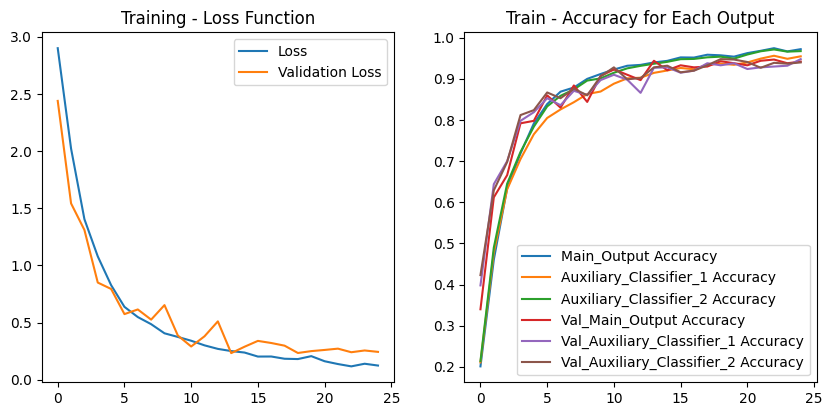

In [ ]:
#Plot loss and accuracy of all 3 branches for train and valid sets

plt.figure(figsize=(10, 10))

# Loss plot
plt.subplot(2, 2, 1)
plt.plot(history2.history['loss'], label='Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

# Accuracy plot for each output
plt.subplot(2, 2, 2)
plt.plot(history2.history['output_1_accuracy'], label='Main_Output Accuracy')
plt.plot(history2.history['output_2_accuracy'], label='Auxiliary_Classifier_1 Accuracy')
plt.plot(history2.history['output_3_accuracy'], label='Auxiliary_Classifier_2 Accuracy')
plt.plot(history2.history['val_output_1_accuracy'], label='Val_Main_Output Accuracy')
plt.plot(history2.history['val_output_2_accuracy'], label='Val_Auxiliary_Classifier_1 Accuracy')
plt.plot(history2.history['val_output_3_accuracy'], label='Val_Auxiliary_Classifier_2 Accuracy')
plt.legend()
plt.title('Train - Accuracy for Each Output')

plt.show()

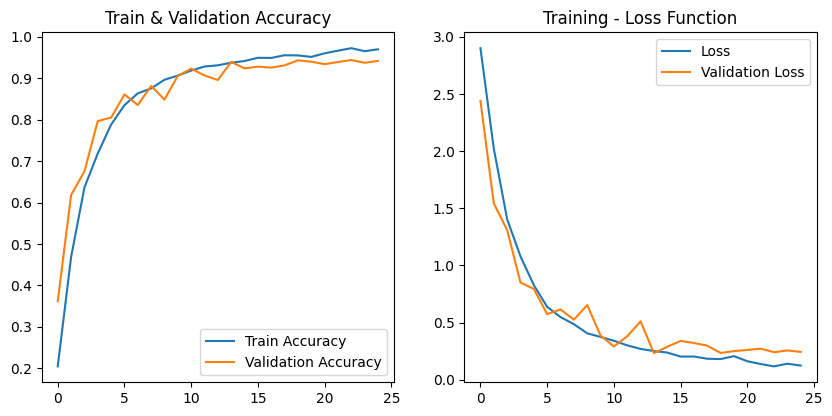

In [22]:
#Plot loss and accuracy by calculating the weighted average of all 3 branches for the train and valid sets

# Loss weight
weight_output_1 = 1
weight_output_2 = 0.1
weight_output_3 = 0.3
total_weight = weight_output_1 + weight_output_2 + weight_output_3

# Calculate weighted accuracy for the train set
train_accuracy = []
for i in range(len(history2.history['output_1_accuracy'])):
    weighted_acc = (
        history2.history['output_1_accuracy'][i] * weight_output_1 +
        history2.history['output_2_accuracy'][i] * weight_output_2 +
        history2.history['output_3_accuracy'][i] * weight_output_3
    ) / total_weight
    train_accuracy.append(weighted_acc)

# Calculate the weighted val_accuracy value for the val set
val_accuracy = []
for i in range(len(history2.history['val_output_1_accuracy'])):
    weighted_val_acc = (
        history2.history['val_output_1_accuracy'][i] * weight_output_1 +
        history2.history['val_output_2_accuracy'][i] * weight_output_2 +
        history2.history['val_output_3_accuracy'][i] * weight_output_3
    ) / total_weight
    val_accuracy.append(weighted_val_acc)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Train & Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history2.history['loss'], label='Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.show()


In [ ]:
model_v1.save('Inception_v1', save_format='tf')